In [2]:
# %matplotlib notebook # comment this line when working in VSCode
%load_ext tensorboard

import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math
import datetime
import os.path

from hera_sim import foregrounds, noise, sigchain, rfi

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold


/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the wa

In [3]:
def plot_one_vis(vis, ylim):
    plt.figure()
    plt.subplot(211); uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,ylim)
    plt.subplot(212); uvtools.plot.waterfall(vis, mode='phs'); plt.colorbar(); plt.ylim(0,ylim)
    plt.show()

MX, DRNG = 2.5, 3

In [4]:
def load_data(*args):
    # load and configure the dataset
    dataset = np.load(args[0])
    labels = np.load(args[1])
    print(f'Dataset imported from {args[0]}')
    X, y = dataset, labels
    print(f"Dataset shape: {X.shape}")
    
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    print(f"X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}")
    n_features = (X_train.shape[1], X_train.shape[2])
#     print(n_features)
    return X, y, X_train, y_train, X_test, y_test, n_features

def load_data_cv():
    # load and configure the dataset
    i = 1
    while(os.path.isfile(f'dataset{i+1}.npy')):
        i = i+1
    dataset = np.load(f'dataset{i}.npy')
    labels = np.load(f'labels{i}.npy')
    print(f'Dataset imported from dataset{i}.npy')
    X, y = dataset, labels
    print(f"Dataset shape: {X.shape}")
    n_features = (X.shape[1], X.shape[2])
    return X, y, n_features

def create_model(n_features):
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=n_features))
    model.add(layers.Dense(25, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dense(8, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
    return model

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # logs for TensorBoard
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # fit the model
    history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0, validation_split=0.2, callbacks=[tensorboard_callback]) 

    # evaluate the model
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print('Test Accuracy: %.3f' % acc)

    # make predictions
    predictions = model.predict_classes(X_test)
    predictions = predictions.flatten()
    # model.summary()
    return history, acc, predictions


- ReLu activation function: for x, it returns max(0, x)
- He weight initialization is a good option: https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78

In [7]:
def get_faulty_predictions(predictions, labels):
    my_list = []
    for i, val in enumerate(predictions):
        if predictions[i] != labels[i]:
            my_list.append(i)
    return my_list

def print_stats(accs, faulty_predictions, predictions):
    print(f"Mean accuracy: {np.mean(accs)}")
    print(f"Standard dev.: {np.std(accs)}")
    l = []
    for val in faulty_predictions:
        l.append(predictions[val])
    if np.bincount(l)[0]:
        print(f"0's (RFI misclassified as clean): {np.bincount(l)[0]}")
    if np.bincount(l)[1]:
        print(f"1's (clean misclassified as RFI): {np.bincount(l)[1]}")

def show_learning_curves(history):
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
#     plt.yscale("log")
    plt.legend()
    plt.show()
    
def show_layer_outputs(model, X):
    for i, val in enumerate(model.layers):
        plt.imshow(model.layers[i].output, aspect="auto")
#     inp = model.input
#     outputs = [layer.output for layer in model.layers]
#     functor = K.function([inp, K.learning_phase()], outputs )
#     layer_outs = functor([X, 1.])
#     plt.imshow(layer_outs, aspect="auto")
    

# No Cross-validation

Dataset imported from dataset3.npy
Dataset shape: (1200, 20, 2048)
X_train.shape: (960, 20, 2048), X_test.shape: (240, 20, 2048)
Test Accuracy: 0.988


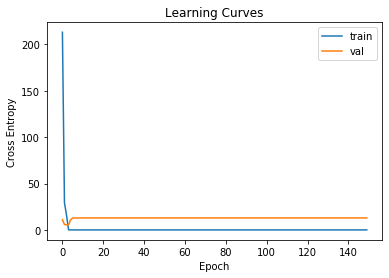

Mean accuracy: 0.987500011920929
Standard dev.: 0.0
0's (RFI misclassified as clean): 0
1's (clean misclassified as RFI): 3
Test Accuracy: 1.000


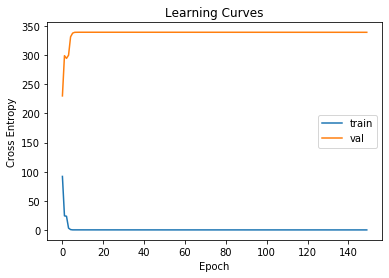

Mean accuracy: 0.9937499761581421
Standard dev.: 0.0062499940395355225
0's (RFI misclassified as clean): 3


IndexError: index 1 is out of bounds for axis 0 with size 1

In [6]:
X, y, X_train, y_train, X_test, y_test, n_features = load_data('dataset3.npy', 'labels3.npy')
faulty_predictions = []
accs = []


for i in range(4):
    model = None
    model = create_model(n_features)

    history, acc, predictions = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    accs.append(acc)
    faulty_predictions.extend(get_faulty_predictions(predictions, y_test))

    show_learning_curves(history)

    print_stats(accs, faulty_predictions, predictions)



# print(layer_output.shape)

In [116]:
# SHOW INTERMEDIATE LAYERS

# f0 = K.function(inputs = model.layers[0].input, outputs = model.layers[0].output)
# f1 = K.function(inputs = model.layers[0].input, outputs = model.layers[1].output)
# f2 = K.function(inputs = model.layers[0].input, outputs = model.layers[2].output)
# f3 = K.function(inputs = model.layers[0].input, outputs = model.layers[3].output)
# l0 = f0(X)
# l1 = f1(X)
# l2 = f2(X)
# l3 = f3(X)
# plt.imshow(l1, aspect="auto")

In [117]:
# VISUALIZE FAULTY PREDICTIONS
#
# for i, val in enumerate(X):
#     if i in faulty_predictions:
#         print(f'Predicted: {predictions[i]}')
#         plot_one_vis(val, 20)

# Stratified K-fold Cross-validation

In [31]:
'''
n_splits = 3
X, y, n_features = load_data_cv()
skf = StratifiedKFold(n_splits, shuffle=True)

accs = []
faulty_predictions=[]

for i in range(4):
    print(f"Run {i}")
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # print(len(X[test_index]), len(y[train_index]))
        print("Running Fold", i+1, "/", n_splits)
        model = None # clear the NN
        model = create_model(n_features)
        history, acc, predictions = train_and_evaluate_model(model, X[train_index], y[train_index], X[test_index], y[test_index])
        accs.append(acc)
        faulty_predictions.extend(get_faulty_predictions(predictions, y[test_index]))
        
    show_learning_curves(history)
    print_stats(accs, faulty_predictions, predictions)
'''

'\nn_splits = 3\nX, y, n_features = load_data_cv()\nskf = StratifiedKFold(n_splits, shuffle=True)\n\naccs = []\nfaulty_predictions=[]\n\nfor i in range(4):\n    print(f"Run {i}")\n    for i, (train_index, test_index) in enumerate(skf.split(X, y)):\n        # print(len(X[test_index]), len(y[train_index]))\n        print("Running Fold", i+1, "/", n_splits)\n        model = None # clear the NN\n        model = create_model(n_features)\n        history, acc, predictions = train_and_evaluate_model(model, X[train_index], y[train_index], X[test_index], y[test_index])\n        accs.append(acc)\n        faulty_predictions.extend(get_faulty_predictions(predictions, y[test_index]))\n        \n    show_learning_curves(history)\n    print_stats(accs, faulty_predictions, predictions)\n'